In [ ]:
import numpy as np
import os

from type_definitions.test_case import TestCase
from type_definitions.test_result import TestResult
from type_definitions.utils import *
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import OPTICS
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
save_plot = False
use_cached_distance_matrix = True  # Set to False to force recalculation

In [3]:
np.random.seed(seed)

cases = generate_cases(80)
results = evaluate_cases(cases)
trajectories = [r.trajectory for r in results if not r.simulation_failed]
valid_results = [r for r in results if not r.simulation_failed]

In [ ]:
os.makedirs("cache", exist_ok=True)
distance_matrix_file = f"cache/distance_matrix_seed{seed}_size{len(trajectories)}.npy"

if use_cached_distance_matrix and os.path.exists(distance_matrix_file):
    print(f"Loading distance matrix from {distance_matrix_file}")
    distance_matrix = np.load(distance_matrix_file)
else:
    print("Calculating pairwise distances...")
    distance_matrix = pairwise_distances(trajectories)
    np.save(distance_matrix_file, distance_matrix)
    print(f"Distance matrix saved to {distance_matrix_file}")

print(f"Distance matrix shape: {distance_matrix.shape}")

# DBSCAN
dbscan = DBSCAN(eps=3000, min_samples=3, metric="precomputed")
clusters = dbscan.fit_predict(distance_matrix)
unique_clusters = np.unique(clusters)

# Calculate cluster statistics
print("Cluster statistics:")
for cluster_id in unique_clusters:
    if cluster_id == -1:  # Skip noise points
        continue
    cluster_mask = clusters == cluster_id
    cluster_results = [
        valid_results[i] for i in range(len(valid_results)) if cluster_mask[i]
    ]
    crashed_in_cluster = sum(1 for r in cluster_results if r.crashed)
    total_in_cluster = len(cluster_results)
    crash_rate = (
        (crashed_in_cluster / total_in_cluster) * 100 if total_in_cluster > 0 else 0
    )
    print(
        f"    Cluster {cluster_id}: {crashed_in_cluster}/{total_in_cluster} crashed ({crash_rate:.2f}%)"
    )

Cluster statistics:
    Cluster 0: 4/6 crashed (66.67%)
    Cluster 1: 12/19 crashed (63.16%)
    Cluster 2: 0/4 crashed (0.00%)
    Cluster 3: 0/6 crashed (0.00%)


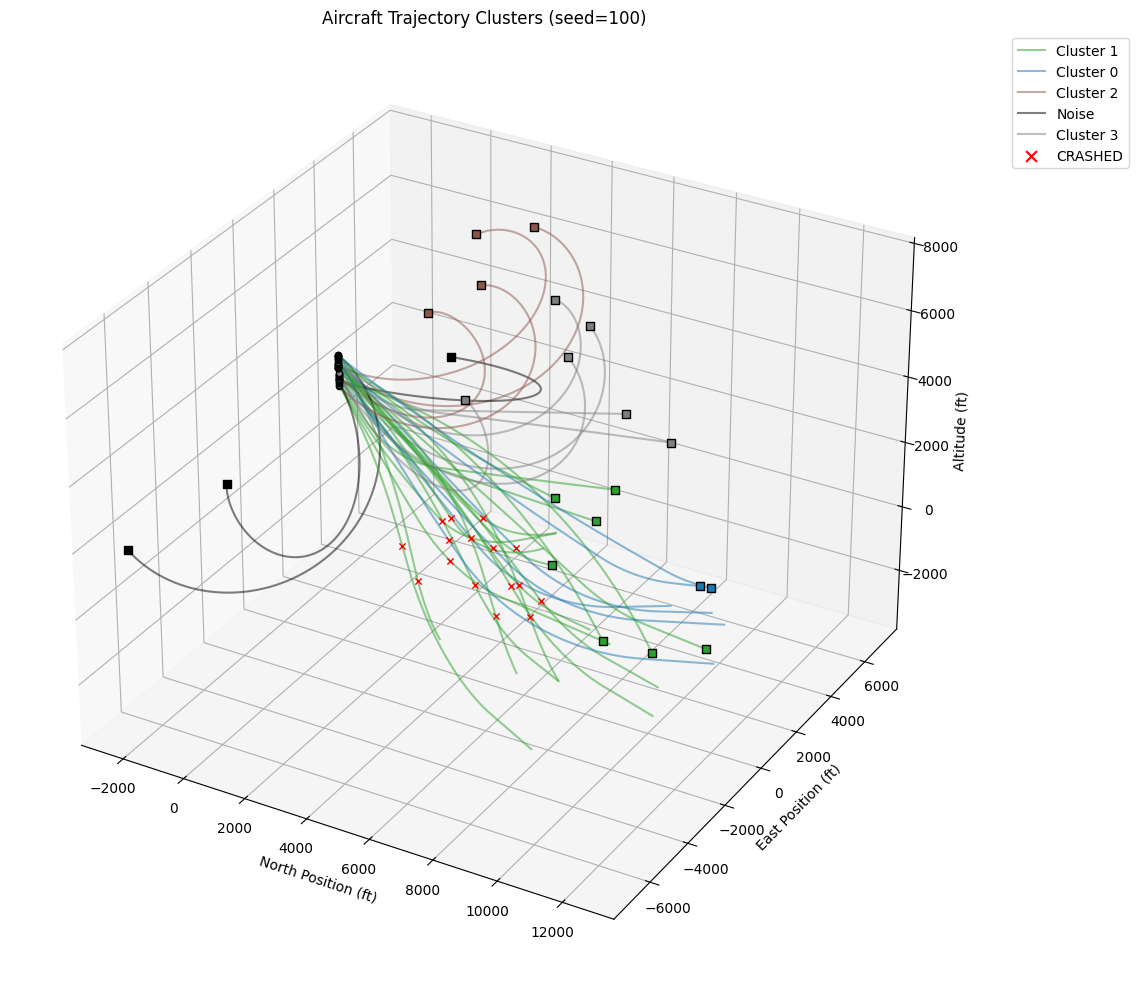

In [ ]:
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection="3d")

colors = plt.get_cmap("tab10")(np.linspace(0, 1, len(unique_clusters)))

valid_results = [r for r in results if not r.simulation_failed]

plotted_clusters = set()
plotted_noise = False

for i, (traj, cluster_id, result) in enumerate(
    zip(trajectories, clusters, valid_results)
):
    if cluster_id == -1:  # noise points in DBSCAN
        color = "black"
        if not plotted_noise:
            label = "Noise"
            plotted_noise = True
        else:
            label = None
    else:
        color = colors[cluster_id % len(colors)]
        if cluster_id not in plotted_clusters:
            label = f"Cluster {cluster_id}"
            plotted_clusters.add(cluster_id)
        else:
            label = None

    # Check for unsafe g-forces
    has_unsafe_g = has_unsafe_gforces(traj)
    line_style = "--" if has_unsafe_g else "-"

    ax.plot(
        traj[:, 0],
        traj[:, 1],
        traj[:, 2],
        color=color,
        alpha=0.5,
        linewidth=1.5,
        linestyle=line_style,
        label=label,
    )

    # start point
    ax.scatter(
        traj[0, 0],
        traj[0, 1],
        traj[0, 2],
        color=color,
        s=20,
        marker="o",
        edgecolor="black",
        linewidth=1,
    )

    # end points
    if result.crashed:
        # ax.scatter(
        #     traj[-1, 0],
        #     traj[-1, 1],
        #     traj[-1, 2],
        #     color="red",
        #     s=30,
        #     marker="s",
        #     edgecolor="black",
        #     linewidth=1,
        # )
        # Find the exact crashed point using first time alt <= 0
        crash_idx = np.where(traj[:, 2] <= 0)[0]
        if len(crash_idx) > 0:
            crash_idx = crash_idx[0]  # First occurrence
            crash_x = traj[crash_idx, 0]
            crash_y = traj[crash_idx, 1]
            crash_z = traj[crash_idx, 2]
        else:
            # Fallback to minimum altitude if no point <= 0
            min_alt_idx = np.argmin(result.trajectory[:, 2])
            crash_x = traj[min_alt_idx, 0]
            crash_y = traj[min_alt_idx, 1]
            crash_z = traj[min_alt_idx, 2]

        ax.scatter(
            crash_x,
            crash_y,
            crash_z,
            color="red",
            s=20,
            marker="x",
            linewidth=1,
        )

        # ax.text(
        #     crash_x,
        #     crash_y,
        #     crash_z + 500,
        #     f"{i}",
        #     color="red",
        #     fontsize=10,
        #     fontweight="bold",
        #     ha="center",
        #     va="bottom",
        # )
    else:
        ax.scatter(
            traj[-1, 0],
            traj[-1, 1],
            traj[-1, 2],
            color=color,
            s=30,
            marker="s",
            edgecolor="black",
            linewidth=1,
        )

if any(result.crashed for result in valid_results):
    ax.scatter([], [], color="red", marker="x", s=60, label="CRASHED")

# Add legend for unsafe g-forces
if any(has_unsafe_gforces(traj) for traj in trajectories):
    ax.plot([], [], color="black", linestyle="--", label="UNSAFE G-FORCES")

ax.set_xlabel("North Position (ft)")
ax.set_ylabel("East Position (ft)")
ax.set_zlabel("Altitude (ft)")
ax.set_title(f"Aircraft Trajectory Clusters (seed={seed})")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
if save_plot:
    plt.savefig(f"results/{seed}_clusters_3d.png")
    print(f"Plot saved to results/{seed}_clusters_3d.png")

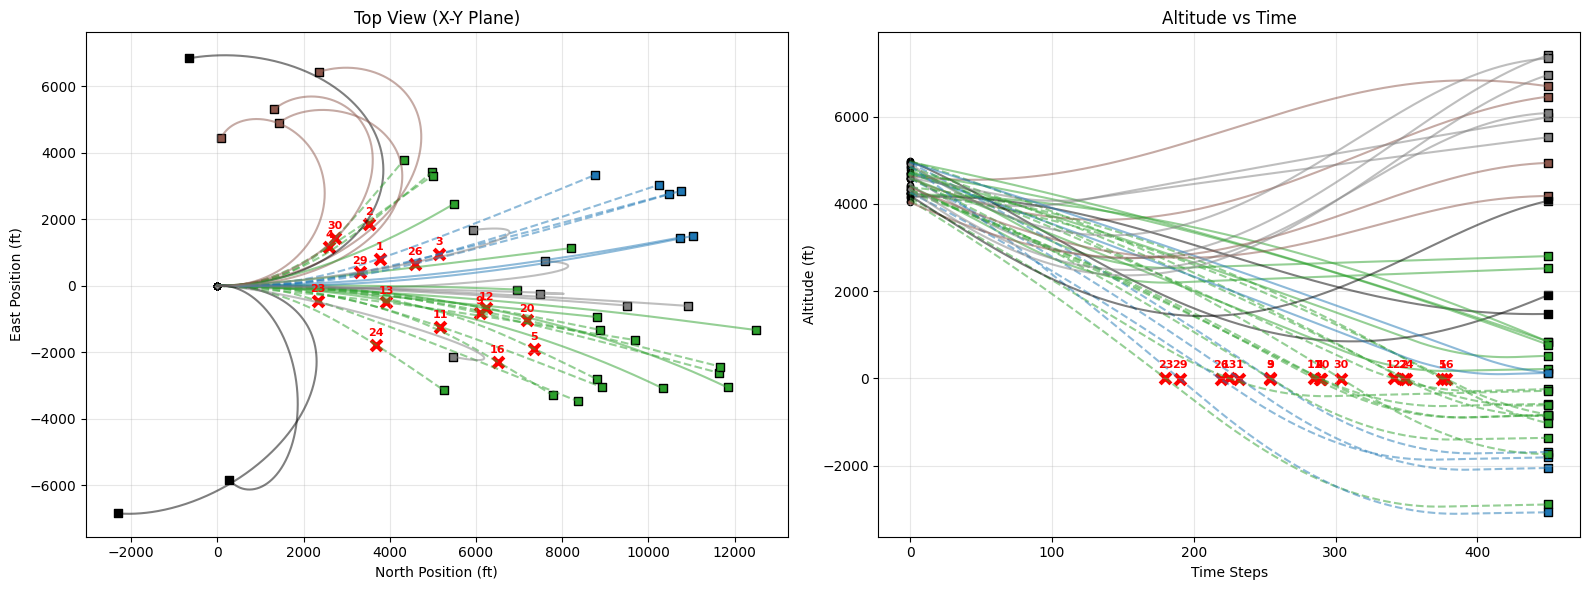

In [ ]:
# 2D plotting - x-y plane and altitude vs time
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# x-y plane
ax1 = axes[0]
for i, (traj, cluster_id, result) in enumerate(
    zip(trajectories, clusters, valid_results)
):
    if cluster_id == -1:
        color = "black"
    else:
        color = colors[cluster_id % len(colors)]

    # Check for unsafe g-forces
    has_unsafe_g = has_unsafe_gforces(traj)
    line_style = "--" if has_unsafe_g else "-"

    if result.crashed:
        ax1.plot(
            traj[:, 0],
            traj[:, 1],
            color=color,
            alpha=0.5,
            linewidth=1.5,
            linestyle=line_style,
        )

        # Find the exact crashed point using first time alt <= 0
        crash_idx = np.where(traj[:, 2] <= 0)[0]
        if len(crash_idx) > 0:
            crash_idx = crash_idx[0]  # First occurrence
            crash_x = traj[crash_idx, 0]
            crash_y = traj[crash_idx, 1]
        else:
            # Fallback to minimum altitude if no point <= 0
            min_alt_idx = np.argmin(result.trajectory[:, 2])
            crash_x = traj[min_alt_idx, 0]
            crash_y = traj[min_alt_idx, 1]

        ax1.scatter(
            crash_x,
            crash_y,
            color="red",
            s=60,
            marker="x",
            linewidth=3,
        )

        ax1.text(
            crash_x,
            crash_y + 200,
            f"{i}",
            color="red",
            fontsize=8,
            fontweight="bold",
            ha="center",
            va="bottom",
        )
    else:
        ax1.plot(
            traj[:, 0],
            traj[:, 1],
            color=color,
            alpha=0.5,
            linewidth=1.5,
            linestyle=line_style,
        )

    ax1.scatter(
        traj[0, 0],
        traj[0, 1],
        color=color,
        s=20,
        marker="o",
        edgecolor="black",
        linewidth=1,
    )

    ax1.scatter(
        traj[-1, 0],
        traj[-1, 1],
        color=color,
        s=30,
        marker="s",
        edgecolor="black",
        linewidth=1,
    )

ax1.set_xlabel("North Position (ft)")
ax1.set_ylabel("East Position (ft)")
ax1.set_title("Top View (X-Y Plane)")
ax1.grid(True, alpha=0.3)

# altitude vs time
ax2 = axes[1]
for i, (traj, cluster_id, result) in enumerate(
    zip(trajectories, clusters, valid_results)
):
    if cluster_id == -1:
        color = "black"
    else:
        color = colors[cluster_id % len(colors)]

    time_steps = np.arange(len(traj))

    # Check for unsafe g-forces
    has_unsafe_g = has_unsafe_gforces(traj)
    line_style = "--" if has_unsafe_g else "-"

    if result.crashed:
        ax2.plot(
            time_steps,
            traj[:, 2],
            color=color,
            alpha=0.5,
            linewidth=1.5,
            linestyle=line_style,
        )

        # Find the exact crashed point using first time alt <= 0
        crash_idx = np.where(traj[:, 2] <= 0)[0]
        if len(crash_idx) > 0:
            crash_idx = crash_idx[0]  # First occurrence
            crash_time = time_steps[crash_idx]
            crash_z = traj[crash_idx, 2]
        else:
            # Fallback to minimum altitude if no point <= 0
            min_alt_idx = np.argmin(result.trajectory[:, 2])
            crash_time = time_steps[min_alt_idx]
            crash_z = traj[min_alt_idx, 2]

        ax2.scatter(
            crash_time,
            crash_z,
            color="red",
            s=60,
            marker="x",
            linewidth=3,
        )

        ax2.text(
            crash_time,
            crash_z + 200,
            f"{i}",
            color="red",
            fontsize=8,
            fontweight="bold",
            ha="center",
            va="bottom",
        )
    else:
        ax2.plot(
            time_steps,
            traj[:, 2],
            color=color,
            alpha=0.5,
            linewidth=1.5,
            linestyle=line_style,
        )

    ax2.scatter(
        0,
        traj[0, 2],
        color=color,
        s=20,
        marker="o",
        edgecolor="black",
        linewidth=1,
    )

    ax2.scatter(
        len(traj) - 1,
        traj[-1, 2],
        color=color,
        s=30,
        marker="s",
        edgecolor="black",
        linewidth=1,
    )

ax2.set_xlabel("Time Steps")
ax2.set_ylabel("Altitude (ft)")
ax2.set_title("Altitude vs Time")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
if save_plot:
    plt.savefig(f"results/{seed}_clusters_2d.png")
    print(f"2D plots saved to results/{seed}_clusters_2d.png")